# Deepfake detection using GAN

In [88]:
# Imports
import numpy as np
import torch
import torchvision as tv
import math

# Plotting
import seaborn as sns
import matplotlib
from tqdm import tqdm

In [89]:
# Configure plots
matplotlib.style.use('seaborn-poster')  # Poster = big, paper = small
matplotlib.style.use('ggplot')
matplotlib.rcParams['font.family'] = 'serif'
sns.set_context('poster')   # Poster = big, paper = small


Controlling seeds to control reproducability.

In [90]:
# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [91]:
# Paths
train_set = "train/"
test_set = "test_set/"

In [92]:
# Load the real part of the train dataset
train_set_real = tv.datasets.ImageFolder(
    root=train_set + "real",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

# Use dataloader to get batches
dataloader_real = torch.utils.data.DataLoader(
    train_set_real, batch_size=batch_size, shuffle=True
)

# Load the fake part of the train dataset
train_set_fake = tv.datasets.ImageFolder(
    root=train_set + "fake",
    transform=tv.transforms.Compose(
        [
            tv.transforms.Resize(image_size),
            tv.transforms.CenterCrop(image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

# Use dataloader to get batches
dataloader_fake = torch.utils.data.DataLoader(
    train_set_fake, batch_size=batch_size, shuffle=True
)

In [93]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [94]:
# Custom weights initialization called on the discriminator
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

In [95]:
# Create the Discriminator
network = Discriminator()

# Apply weights
network.apply(init_weights)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [96]:
def train_on_batch(batch, label):
	# Format batch
	batch = data[0].to()
	labels = torch.full((batch.size(0),), label, dtype=torch.float)

	# Forward pass batch
	output = network(batch).view(-1)

	# Calculate loss on batch
	loss = loss_fn(output, labels)

	# Backwards pass batch
	loss.backward()
	return loss

In [97]:
# Optimiser
optimiser = torch.optim.Adam(network.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
loss_fn = torch.nn.BCELoss()

losses = []

for epoch in tqdm(range(num_epochs)):
    itfake = iter(dataloader_fake)

    # For each batch in the dataloader
    for i, data in tqdm(enumerate(dataloader_real)):
        # Set gradient to 0
        network.zero_grad()

        # Train with real batch
        loss_real = train_on_batch(data, 1)

        # Train with fake batch
        loss_fake = train_on_batch(next(itfake), 0)

        # Update network
        optimiser.step()

        # Save losses
        loss = loss_real + loss_fake
        losses.append(loss.item())


229it [14:17,  3.74s/it]0:00<?, ?it/s]
71it [02:57,  2.50s/it]14:17<2:08:37, 857.54s/it]
 10%|█         | 1/10 [17:14<2:35:13, 1034.82s/it]


KeyboardInterrupt: 

<AxesSubplot:>

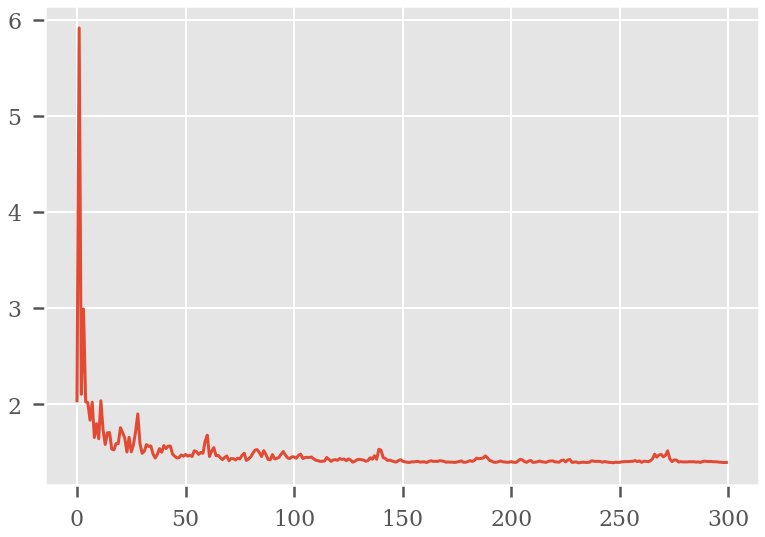

In [104]:
# Plot losses
sns.lineplot(data=losses)

In [ ]:
# Set network in evaluation mode
network.eval()

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
def predict_folder(path):
    videos = tv.datasets.ImageFolder(
        root=path,
        transform=tv.transforms.Compose(
            [
                tv.transforms.Resize(image_size),
                tv.transforms.CenterCrop(image_size),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

    for ind, val in videos.class_to_idx.items():
        low = math.inf
        high = -1
        for i, ele in enumerate(videos.imgs):
            _, idx = ele
            if idx == val:
                if i < low:
                    low = i
                if i > high:
                    high = i
        video = torch.utils.data.Subset(videos, range(low, high))
        results = []
        for frame in video:
            frame = frame[0]
            frame = frame.view(1, *frame.shape)
            results.append(network(frame).view(-1).item())
        print(ind, round(np.mean(results)))


In [ ]:
predict_folder(test_set + 'real')

aeolxtsnfc.mp4 0.5905589994952631
aevbmlbayq.mp4 0.6759592888888365
ahanoygyei.mp4 0.19759264005033492
ahpnrwwibe.mp4 0.15384173472157933
alrhucxcnv.mp4 0.13839082386554769
alypwytrnl.mp4 0.5351399360193456
andnipfbgy.mp4 0.8584229563221787
annsmfhdgk.mp4 0.518357077272014
anzenqcwqo.mp4 0.8192782728144756
apansjedym.mp4 0.5777808462034513
arwiyweadv.mp4 0.9482235454801303
atedpzfvyf.mp4 0.746969811984543
atuzsraaul.mp4 0.1652885067368639
avttogwbyz.mp4 0.22007197718584542


In [ ]:
predict_folder(test_set + 'fake')

abdgairkrk.mp4 0.33292667494088807
abgrdkbhch.mp4 0.4889192778031563
abmdetdeok.mp4 0.5790376174310378
abteztchqz.mp4 0.24500866684723985
accfrqkrni.mp4 0.09813486892316077
acekgkqgdg.mp4 0.34401717920940256
acgyspwyqr.mp4 0.16146630451704064
achekamhkd.mp4 0.14079504231499
acqawykwfs.mp4 0.6637584320627726
adfufsvmcl.mp4 0.38571618486158427
adtftvevja.mp4 0.28750328908995243
advhlnfwag.mp4 0.005666827544664677
aebrgxdalw.mp4 0.5127844590456988
aednqykqfh.mp4 0.6846135742713177
aegeiboeus.mp4 0.9082099830867439
aeplbqxnge.mp4 0.4259011343021855
aezujunliw.mp4 0.9942344278097153
afaxsgqksm.mp4 0.5706606372633333
afwakzqdin.mp4 0.5697233021558328
afynesbqqg.mp4 0.9593592156966527
agblhurdrh.mp4 0.22196758176545833
aglqdsqmim.mp4 0.0976160824516456
agyawnxlmv.mp4 0.8097663615632245
ahcptgydid.mp4 0.9071844589225081
ahvroxnbbr.mp4 0.0976197335582513
aiaxyavqce.mp4 0.3946193940648737
aigufxcoyu.mp4 0.43507490665916615
akcebajhgd.mp4 0.24736512096753965
akdqrdkelr.mp4 0.23026798489062408
akn

c:\Users\NooNoo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\NooNoo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


aslagfljgq.mp4 0.12627369571611824
aspxqtipuv.mp4 0.2434071288701072
aswtwwuiva.mp4 0.769817958585918
asyjnjjldz.mp4 0.05818108767167539
atmalptsdf.mp4 0.19968847752574626
atoeqixpui.mp4 0.6691908991855123
atqtjhcjok.mp4 0.6416502189401998
aufudlkirv.mp4 0.1656785376213196
auyrrevsns.mp4 0.15972212076414632
auysreeedq.mp4 0.6035452732443809
avlbihahvk.mp4 0.8421412706375122
avmrqfwizg.mp4 0.07787714603832586
avqxrnfzpd.mp4 0.8576316237449646
avtdwylihb.mp4 nan
awifeyjgpb.mp4 0.0644773578327336
awzgjaqzyu.mp4 0.9190569953484968
